<a href="https://www.kaggle.com/code/binitamahto/pneumonia-detection3?scriptVersionId=225488423" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
 #   for filename in filenames:
  #      print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = 150
batch_size = 32

train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# ✅ Training Data
train_generator = train_datagen.flow_from_directory(
    directory='/kaggle/input/chest-xray-pneumonia/chest_xray/train/',  # Use train folder
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

# ✅ Validation Data
val_generator = train_datagen.flow_from_directory(
    directory='/kaggle/input/chest-xray-pneumonia/chest_xray/train/',  # Still using train (with subset)
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

# ✅ Test Data (No subset needed)
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    directory='/kaggle/input/chest-xray-pneumonia/chest_xray/test/',  # Use test folder
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False  # No need to shuffle test data
)

# ✅ Check Class Labels
print("Class labels:", train_generator.class_indices)


Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Class labels: {'NORMAL': 0, 'PNEUMONIA': 1}


In [3]:
# Define paths
train_path = "/kaggle/input/chest-xray-pneumonia/chest_xray/train/"
val_path = "/kaggle/input/chest-xray-pneumonia/chest_xray/val/"
test_path = "/kaggle/input/chest-xray-pneumonia/chest_xray/test/"

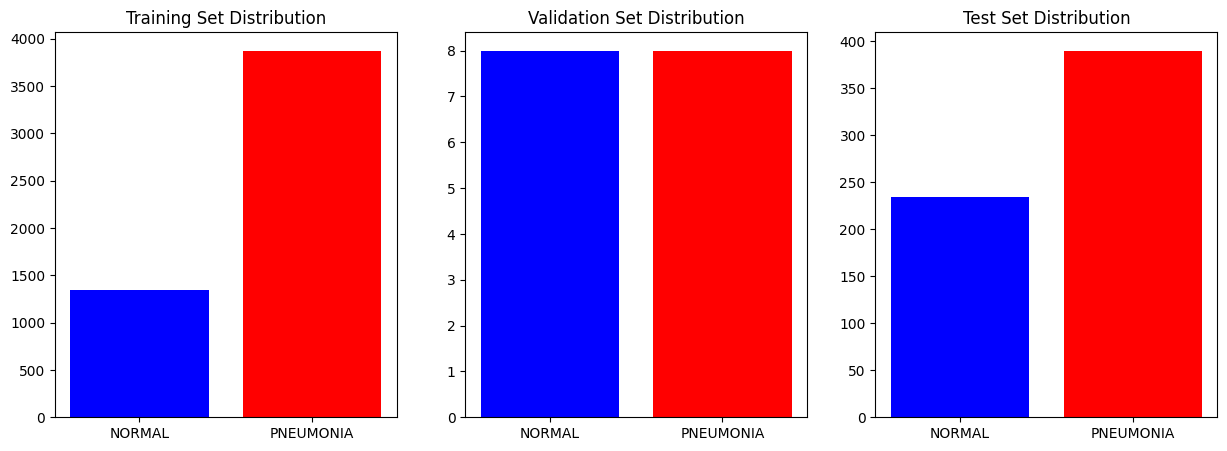

In [4]:
import os
import matplotlib.pyplot as plt

# Function to count images in each category
def count_images(directory):
    return {category: len(os.listdir(os.path.join(directory, category))) for category in ["NORMAL", "PNEUMONIA"]}

# Get image counts
train_counts = count_images("/kaggle/input/chest-xray-pneumonia/chest_xray/train/")
val_counts = count_images("/kaggle/input/chest-xray-pneumonia/chest_xray/val/")
test_counts = count_images("/kaggle/input/chest-xray-pneumonia/chest_xray/test/")

# Plot distribution
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i, (dataset, counts) in enumerate(zip(["Training", "Validation", "Test"], [train_counts, val_counts, test_counts])):
    ax[i].bar(counts.keys(), counts.values(), color=['blue', 'red'])
    ax[i].set_title(f"{dataset} Set Distribution")

plt.show()


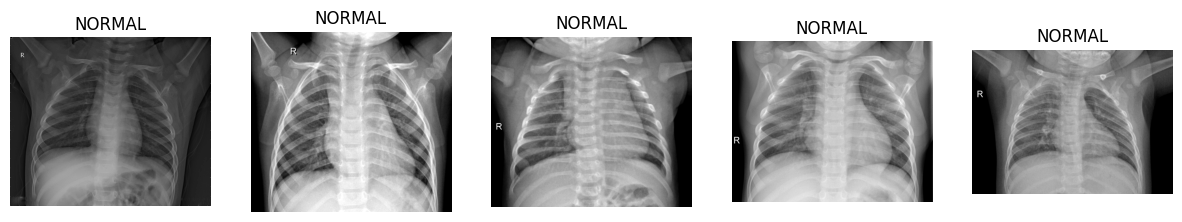

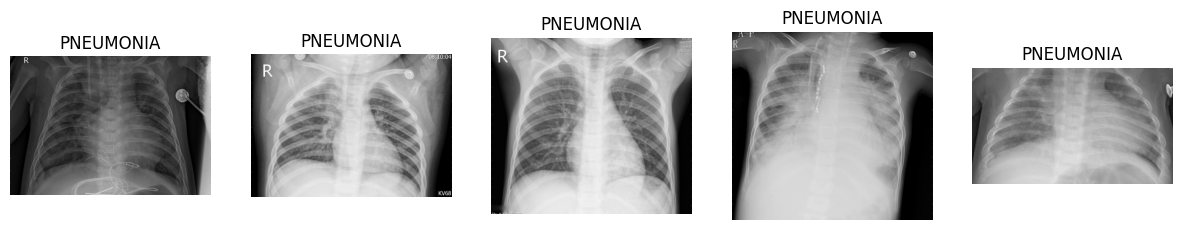

In [5]:
import cv2

# Function to plot images
def plot_images(category, dataset_path, num_images=5):
    folder_path = os.path.join(dataset_path, category)
    image_files = os.listdir(folder_path)[:num_images]  # Select first few images

    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i, img_file in enumerate(image_files):
        img = cv2.imread(os.path.join(folder_path, img_file), cv2.IMREAD_GRAYSCALE)  # Read image
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(category)
        axes[i].axis('off')

    plt.show()

# Show images from both categories
plot_images("NORMAL", train_path)
plot_images("PNEUMONIA", train_path)

In [6]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,  # Rotate images randomly
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
    validation_split=0.2
)
# Training Generator
train_generator = train_datagen.flow_from_directory(
    directory=train_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

Found 4173 images belonging to 2 classes.


In [7]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Load pre-trained VGG19 without top layers
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

# Unfreeze last 3 layers for fine-tuning
for layer in base_model.layers[-6:]:
    layer.trainable = True

# Add custom classifier on top with L2 regularization
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.4),  # Slightly increased dropout
    Dense(1, activation='sigmoid')
])

# Compile with a slightly reduced learning rate
model.compile(optimizer=Adam(learning_rate=0.00005), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

# Train with EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=[early_stop],
    verbose=1
)

# Evaluate on test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Loss of the model is - {test_loss}")
print(f"Accuracy of the model is - {test_accuracy * 100} %")


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)                   │ (None, 4, 4, 512)           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       2,097,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,122,049 (84.39 MB)

 Trainable params: 22,122,049 (84.39 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


131/131 ━━━━━━━━━━━━━━━━━━━━ 112s 708ms/step - accuracy: 0.8590 - loss: 4.6835 - val_accuracy: 0.9530 - val_loss: 3.0897
Epoch 2/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 63s 456ms/step - accuracy: 0.9473 - loss: 2.8030 - val_accuracy: 0.9396 - val_loss: 2.0256
Epoch 3/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 59s 428ms/step - accuracy: 0.9556 - loss: 1.8228 - val_accuracy: 0.8610 - val_loss: 1.6138
Epoch 4/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 59s 428ms/step - accuracy: 0.9606 - loss: 1.2802 - val_accuracy: 0.9473 - val_loss: 1.0218
Epoch 5/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 59s 429ms/step - accuracy: 0.9562 - loss: 0.9477 - val_accuracy: 0.9607 - val_loss: 0.7652
Epoch 6/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 59s 427ms/step - accuracy: 0.9649 - loss: 0.7176 - val_accuracy: 0.9569 - val_loss: 0.6375
Epoch 7/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 59s 431ms/step - accuracy: 0.9707 - loss: 0.5855 - val_accuracy: 0.9645 - val_loss: 0.5273
Epoch 8/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 59s 428ms/step - accuracy: 0.9699 - loss: 0.4940 - va

In [8]:
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]

print(f"Train Accuracy: {train_acc:.2f}")
print(f"Validation Accuracy: {val_acc:.2f}")


Train Accuracy: 0.99
Validation Accuracy: 0.94


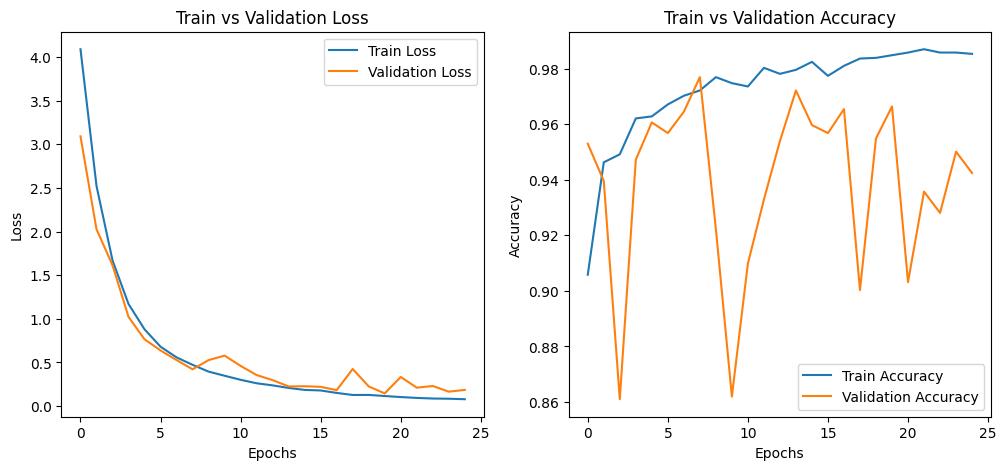

In [9]:
plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Train vs Validation Loss')

# Accuracy Plot
plt.subplot(1, 2, 2) 
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Train vs Validation Accuracy')

plt.show()

20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 210ms/step
              precision    recall  f1-score   support

      Normal       0.98      0.76      0.85       234
   Pneumonia       0.87      0.99      0.93       390

    accuracy                           0.90       624
   macro avg       0.92      0.87      0.89       624
weighted avg       0.91      0.90      0.90       624



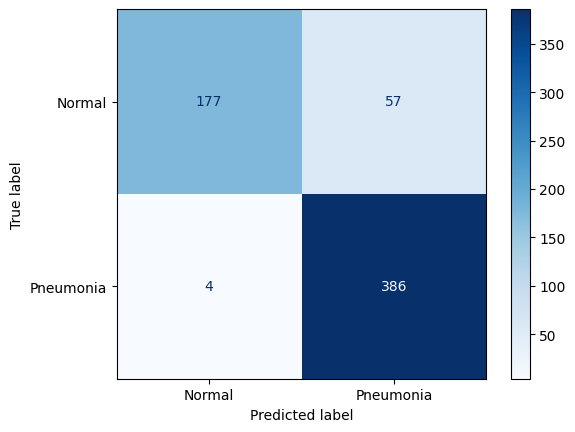

In [10]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Get true labels and predictions
true_labels = test_generator.classes
predictions = (model.predict(test_generator) > 0.5).astype("int32")

# Classification Report
print(classification_report(true_labels, predictions, target_names=['Normal', 'Pneumonia']))

# Confusion Matrix
cm = confusion_matrix(true_labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Pneumonia'])
disp.plot(cmap='Blues')
plt.show()

In [11]:
from tensorflow.keras.models import load_model
model.save("cnn_model.h5")  # Save Model

# Load Model for Future Predictions
loaded_model = load_model("cnn_model.h5")


In [12]:
from tensorflow.keras.preprocessing import image


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


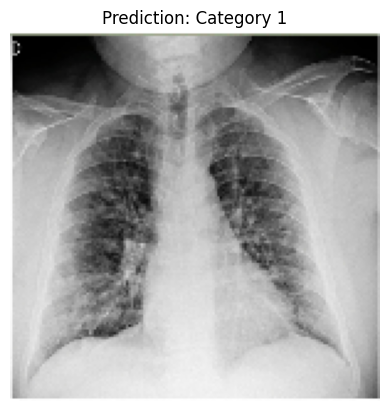

In [13]:
def predict_image(img_path, model):
    img = image.load_img(img_path, target_size=(150, 150))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalize

    prediction = model.predict(img_array)
    class_name = "Category 1" if prediction[0][0] > 0.5 else "Category 0"

    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Prediction: {class_name}")
    plt.show()

# Example
predict_image("/kaggle/input/pnemonia/pneumonia.jpeg", loaded_model)
